In [1]:
# pmdarima
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dataset = pd.read_csv("data1.csv")
feature = 'sm'
steps = -1
dataset['Date'] = pd.to_datetime(dataset['ttime'])
# dataset = dataset.loc[(dataset['Date'] > '2022-7-02') ]
dataset = dataset.reset_index(drop = True)
# print(dataset.head())
dataset_for_prediction = dataset.copy()
dataset_for_prediction['Actual'] = dataset_for_prediction[feature].shift(steps)
dataset_for_prediction = dataset_for_prediction.dropna()
dataset_for_prediction['Date'] = pd.to_datetime(dataset_for_prediction['ttime'])

                 ttime   pm1  pm2  pm3   am      sm     st      lum  \
0  2022-07-18 15:42:55  3.63  0.0  0.0  3.2  7813.0  25.65  15001.0   
1  2022-07-18 15:47:55  4.19  0.0  0.0  4.8  7692.0  25.66  13863.0   
2  2022-07-18 15:52:55  4.74  0.0  0.0  4.0  7813.0  25.67  13788.0   
3  2022-07-18 15:57:55  5.30  0.0  0.0  4.8  7813.0  25.68  14383.0   
4  2022-07-18 16:02:55  0.55  5.3  5.3  3.2  7813.0  25.69  14621.0   

                 Date  
0 2022-07-18 15:42:55  
1 2022-07-18 15:47:55  
2 2022-07-18 15:52:55  
3 2022-07-18 15:57:55  
4 2022-07-18 16:02:55  


In [3]:
from sklearn.preprocessing import MinMaxScaler

sc_in = MinMaxScaler(feature_range=(0, 1))
scaled_input = sc_in.fit_transform(dataset_for_prediction[[feature]])
scaled_input = pd.DataFrame(scaled_input)
X = scaled_input
X = X.rename(columns={0:feature})

In [4]:
sc_out = MinMaxScaler(feature_range=(0, 1))
scaler_output = sc_out.fit_transform(dataset_for_prediction[['Actual']])
scaler_output = pd.DataFrame(scaler_output)
y = scaler_output
y = y.rename(columns={0:'Actual'})
y.index = dataset_for_prediction.index

In [5]:
train_size = int(len(dataset) * 0.7)
test_size = int(len(dataset)) - train_size
train_X, train_y = X[:train_size].dropna(), y[:train_size].dropna()
test_X, test_y = X[train_size:].dropna(), y[train_size:].dropna()

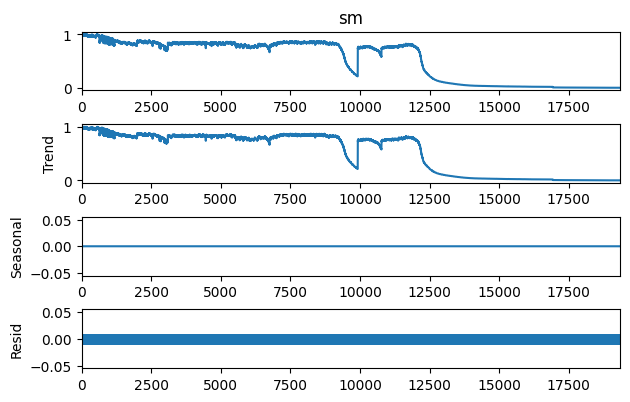

In [6]:
import statsmodels.api as sm

seas_d = sm.tsa.seasonal_decompose(X[feature], model='add', period=1)
fig = seas_d.plot()
fig.set_figheight(4)
plt.show()

In [7]:
def test_adf(series, title=''):
    dfout={}
    dftest = sm.tsa.adfuller(series.dropna(), autolag='AIC', regression='ct')
    for key, val in dftest[4].items():
        dfout[f'critical value ({key})']=val
    if dftest[1] <= 0.05:
        print("Strong evidence against Null Hypothesis")
        print("Reject Null Hypothesis - Data is Stationary")
        print("Data is Stationary", title)
    else:
        print("Strong evidence for Null Hypothesis")
        print("Accept Null Hypothesis - Data is not Stationary")
        print("Data is NOT Stationary for", title)

In [8]:
y_test = y['Actual'][:train_size].dropna()
test_adf(y_test, "Soil Moisture")

Strong evidence for Null Hypothesis
Accept Null Hypothesis - Data is not Stationary
Data is NOT Stationary for Soil temperature


/Users/cebajel/miniconda3/envs/hello/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


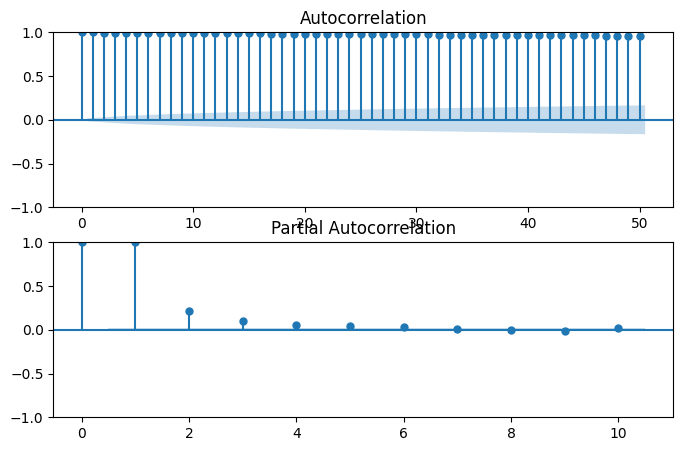

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(8, 5))
fig = sm.tsa.graphics.plot_acf(y_test, lags=50, ax=ax[0])
fig = sm.tsa.graphics.plot_pacf(y_test, lags=10, ax=ax[1])
plt.show()

In [75]:
from pmdarima.arima import auto_arima

step_wise = auto_arima(train_y, exogenous= train_X, start_p=1, start_q=1,
                        max_p=7, max_q=7, d=0, max_d=7, trace=True,
                          error_action='ignore', suppress_warnings=True, stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-82918.823, Time=1.86 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-2281.624, Time=0.71 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.95 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-19794.879, Time=1.68 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=31421.034, Time=0.16 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-83068.978, Time=1.56 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=1.56 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-80631.260, Time=17.15 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-83085.732, Time=3.73 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-83065.550, Time=8.56 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-81794.424, Time=21.01 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-83097.873, Time=8.27 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-83090.681, Time=7.54 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-83089.628, Time=12.01 sec
 ARIMA(2,0,4)(0,0,

In [76]:
step_wise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                13538
Model:               SARIMAX(1, 0, 4)   Log Likelihood               41556.685
Date:                Sat, 25 Mar 2023   AIC                         -83099.371
Time:                        12:34:07   BIC                         -83046.778
Sample:                             0   HQIC                        -83081.833
                              - 13538                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.463e-05      0.000      0.336      0.737      -0.000       0.000
ar.L1          0.9999      0.000   5881.559      0.000       1.000       1.000
ma.L1         -0.3210      0.001   -237.400      0.000      -0.324      -0.318
ma.L2         -0.0810      0.002    -34.577      0.000      -0.086      -0.076
ma.L3         -0.0324      0.003    -10.591      0.000      -0.038      -0.026
ma.L4         -0.0260      0.003     -7.647      0.000      -0.033      -0.019
sigma2         0.0001   1.28e-07    985.392      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):          78647542.47
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.45   Skew:                             8.04
Prob(H) (two-sided):                  0.00   Kurtosis:                       376.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_y, exog=train_X, order=(1, 0, 4), enforce_invertibility=False, enforce_stationarity=False)
results = model.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.06867D+00    |proj g|=  1.31753D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      2     13      1     0     0   1.253D-02  -3.069D+00
  F =  -3.0687256291904585     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [11]:
predictions = results.predict(start = train_size, end=train_size + test_size + (steps) - 1, exog=test_X)

In [12]:
# free = np.zeros(test_X.shape)
# print(free.shape)
# print(test_size - 1)
forecast_1 = results.forecast(steps=test_size - 1, exog=test_X)

In [13]:
act = pd.DataFrame(scaler_output.iloc[train_size:, 0])
act = act.rename(columns={0:'Actual'})

In [14]:
predictions = pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index = test_X.index
predictions['Actual'] = act['Actual']
predictions.rename(columns={'predicted_mean':'Pred'}, inplace=True)
# print(predictions.head())

           Pred    Actual
13538  0.063571  0.063652
13539  0.063664  0.063260
13540  0.063262  0.063260
13541  0.063256  0.063260
13542  0.063254  0.063129


<AxesSubplot: >

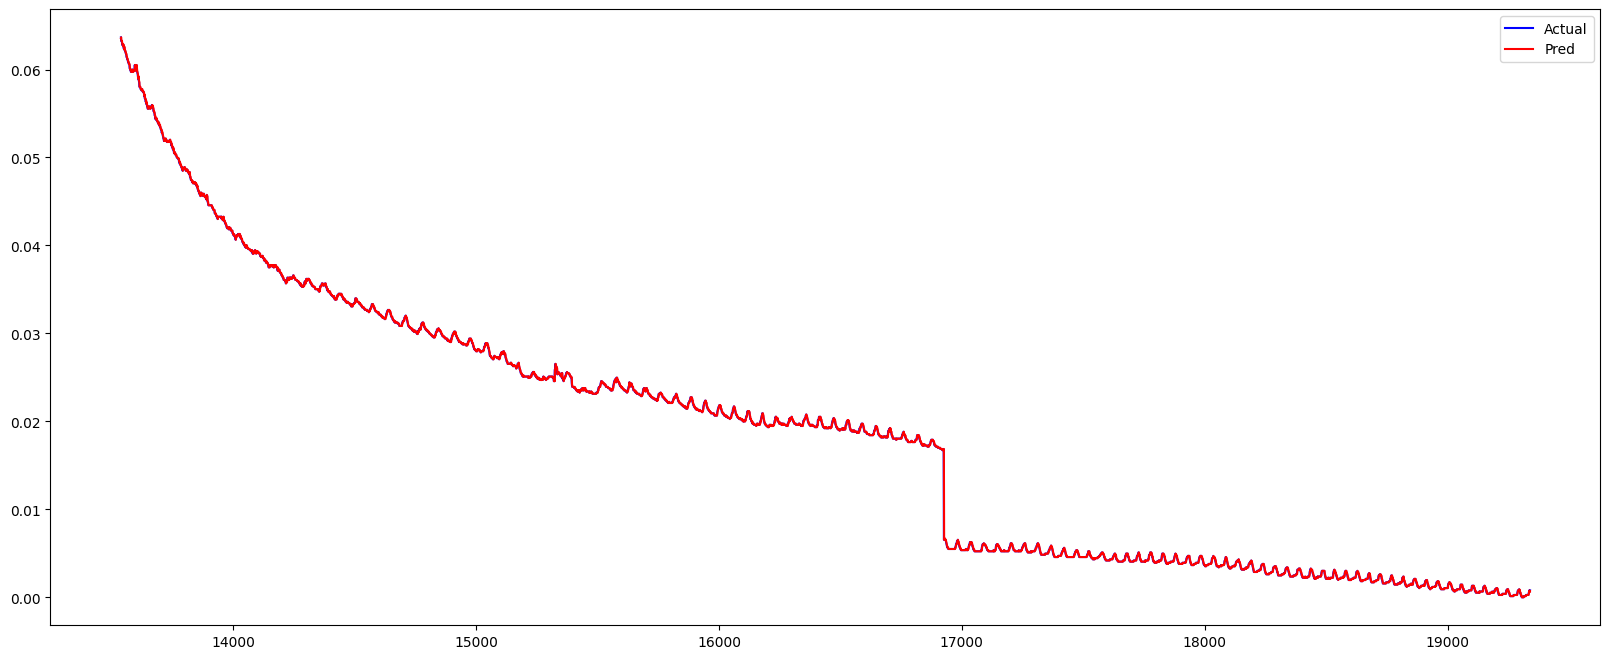

In [15]:
predictions['Actual'].plot(figsize=(20, 8), legend=True, color='blue')
predictions['Pred'].plot(legend=True, color='red', figsize=(20, 8))

In [16]:
forecast_feature = pd.DataFrame(forecast_1)
forecast_feature.reset_index(drop=True, inplace=True)
forecast_feature.index = test_X.index
forecast_feature['Actual'] = scaler_output.iloc[train_size:, 0]
forecast_feature.rename(columns={'predicted_mean':'Forecast'}, inplace=True)

<AxesSubplot: >

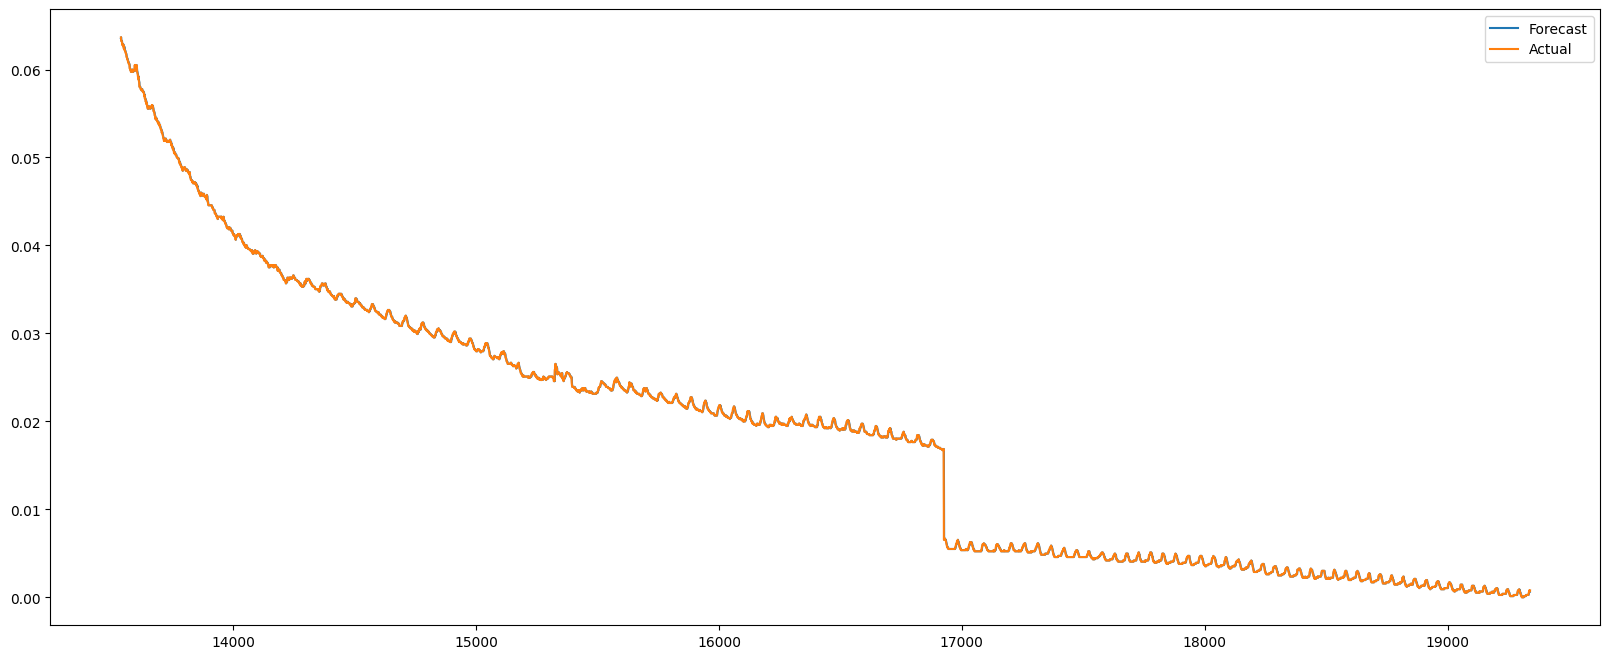

In [17]:
forecast_feature['Forecast'].plot(figsize=(20, 8), legend=True)
forecast_feature['Actual'].plot(figsize=(20, 8), legend=True)

In [18]:
from statsmodels.tools.eval_measures import rmse
error = rmse(predictions['Pred'], predictions['Actual'])
print(error)

0.00016661524963618195


In [19]:
trainPredict = sc_out.inverse_transform(predictions[['Pred']])
testPredict = sc_out.inverse_transform(predictions[['Actual']])

In [20]:
error = rmse(trainPredict, testPredict)
print(error)

[1.27477327]
